# Insights from Failed Orders

## Read and Explore the Datasets

We will use the Pandas library to load the CSVs into a DataFrame structure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Load orders dataset
filepath = "datasets\\datasets\\data_orders.csv"
orders = pd.read_csv(filepath)
print("orders data shape:", orders.shape)
orders.head()

orders data shape: (10716, 8)


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0
2,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0
3,13:50:20,-1.054671,51.460544,658.0,3000582941169,4,1,62.0
4,21:24:45,-0.967605,51.458236,NaN,3000583140877,9,0,NaN


In [22]:
# Load offers dataset
filepath = "datasets\\datasets\\data_offers.csv"
offers = pd.read_csv(filepath)
print("Offers data shape:", offers.shape)
offers.head()

Offers data shape: (334363, 2)


,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [23]:
# Merging the two datasets on order_gk
merged_df = orders.merge(right=offers, how="inner", on="order_gk")
print("Merged data shape:", merged_df.shape)
merged_df.head()

Merged data shape: (31268, 9)


,order_datetime,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,is_driver_assigned_key,cancellations_time_in_seconds,offer_id
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,1,198.0,300050983403
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986179
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986174
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,0,128.0,300050986180
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,1,46.0,300050976275


In [24]:
merged_df['order_status_key'].value_counts()

order_status_key
4    21795
9     9473
Name: count, dtype: int64

Since the values in order_status_key is not informative of the contents but are rather just keys that point to some internal description. We will replace their values with more informative information

In [25]:
merged_df["order_status"] = np.where(merged_df["order_status_key"] == 4, "Client Cancelled", "System Reject")
merged_df["is_driver_assigned"] = np.where(merged_df["is_driver_assigned_key"] == 1, "Yes", "No")

merged_df.drop(columns=["is_driver_assigned_key"], inplace=True)
merged_df = merged_df.rename(columns={
    "order_datetime": "order_time"
})

In [26]:
merged_df.head()

,order_time,origin_longitude,origin_latitude,m_order_eta,order_gk,order_status_key,cancellations_time_in_seconds,offer_id,order_status,is_driver_assigned
0,18:08:07,-0.978916,51.456173,60.0,3000583041974,4,198.0,300050983403,Client Cancelled,Yes
1,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,128.0,300050986179,Client Cancelled,No
2,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,128.0,300050986174,Client Cancelled,No
3,20:57:32,-0.950385,51.456843,NaN,3000583116437,4,128.0,300050986180,Client Cancelled,No
4,12:07:50,-0.969520,51.455544,477.0,3000582891479,4,46.0,300050976275,Client Cancelled,Yes


#### Question 1

Build up a distribution of orders according to reasons for failure: cancellations before and after driver assignment, and reasons for order rejection. Analyse the resulting plot. Which category has the highest number of orders?

is_driver_assigned               No                            Yes  \
order_status       Client Cancelled System Reject Client Cancelled   
order_gk                      13435          9469             8360   

is_driver_assigned                
order_status       System Reject  
order_gk                       4

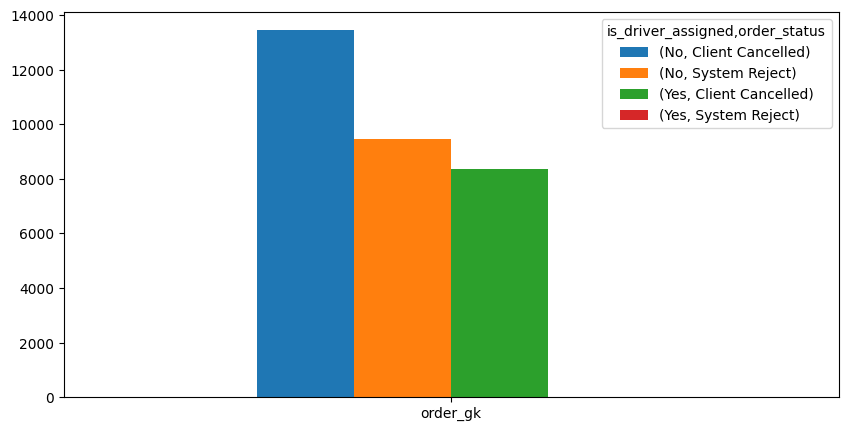

In [17]:
failure_counts = merged_df.pivot_table(columns=["is_driver_assigned", "order_status"], values="order_gk", aggfunc="count")
_ = failure_counts.plot(kind="bar", subplots=False, figsize=(10, 5), legend=True, rot=0)

failure_counts

We observe a high number of orders cancelled before a driver is assigned, implying that maybe customers have waited too long and have decided on an alternative for their transportation needs. We have 13435 orders cancelled by the client, and 9469 rejected by the system. There are 8360 client cancellations after a driver has been assigned, and only four which were rejected by the system.

#### Question 2

Plot the distribution of failed orders by hours. Is there a trend that certain hours have an abnormally high proportion of one category or another? What hours are the biggest fails? How can this be explained?

In [29]:
merged_df['order_time'] = pd.to_datetime(merged_df['order_time'])
merged_df['order_hour'] = merged_df['order_time'].dt.hour

C:\Users\User\AppData\Local\Temp\ipykernel_7808\237231245.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  merged_df['order_time'] = pd.to_datetime(merged_df['order_time'])


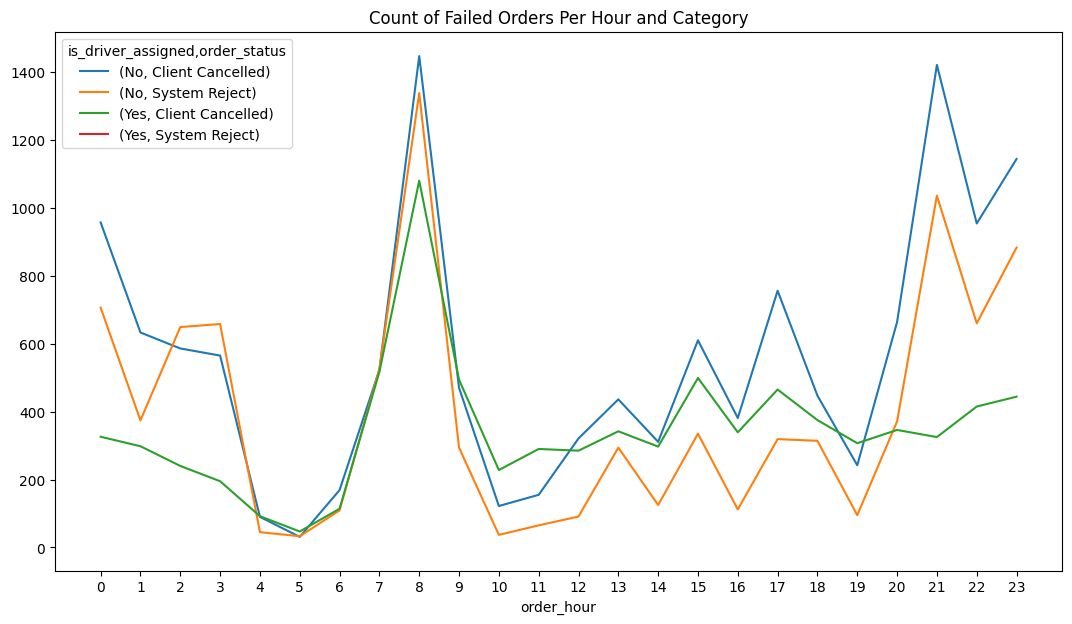

In [19]:
failures = merged_df[merged_df['order_status'].notna()]

hourly_distribution = failures.groupby(by=["order_hour", "is_driver_assigned", "order_status"])["order_gk"].count()

_ = hourly_distribution.reset_index().pivot(index="order_hour",
                                   columns=["is_driver_assigned", "order_status"],
                                   values="order_gk").plot(xticks=range(0, 24),
                                                           figsize=(13, 7),
                                                           title="Count of Failed Orders Per Hour and Category")

In [20]:
hourly_distribution

order_hour  is_driver_assigned  order_status    
0           No                  Client Cancelled     957
                                System Reject        706
            Yes                 Client Cancelled     326
                                System Reject          4
1           No                  Client Cancelled     633
                                                    ... 
22          No                  System Reject        660
            Yes                 Client Cancelled     415
23          No                  Client Cancelled    1144
                                System Reject        883
            Yes                 Client Cancelled     444
Name: order_gk, Length: 73, dtype: int64

The four system rejects with the assigned driver occurred around midnight. The rest of the categories follow similar distribution, with the client cancellations with the assigned driver having a substantially lower count during the night hours.

#### Question 3

Plot the average time to cancellation with and without driver, by hour. Can we draw any conclusions from this plot?

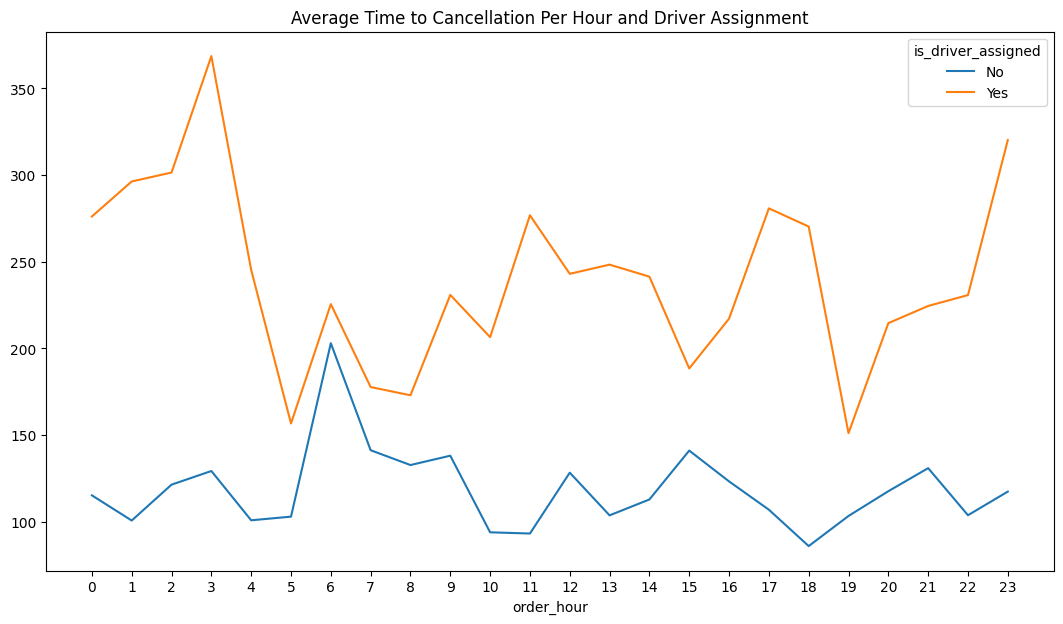

In [30]:
cancellations = merged_df[merged_df['order_status_key'] == 4].copy()

grouped = cancellations.groupby(['order_hour', 'is_driver_assigned'])['cancellations_time_in_seconds'].mean()

_ = grouped.reset_index().pivot(index="order_hour",
                                   columns="is_driver_assigned",
                                   values="cancellations_time_in_seconds").plot(xticks=range(0, 24),
                                                                                figsize=(13, 7),
                                                                                title="Average Time to Cancellation Per Hour and Driver Assignment")

The average time to cancellation is higher on orders with an assigned driver than without, for each hour without exception. The peak occurs at 3 A.M. At this time there are a lot of client cancellations, so a logical explanation would be that clients have waited too long for the driver.

#### Question 4

Plot the distribution of average ETA by hours. How can this plot be explained?

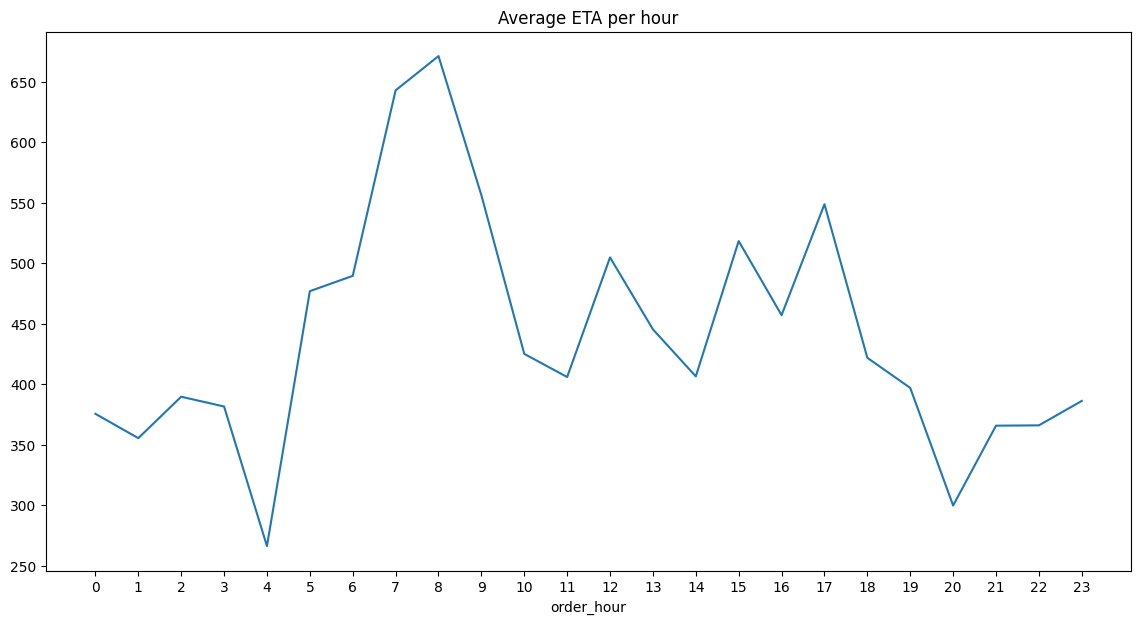

In [31]:
_ = merged_df.groupby(by="order_hour")["m_order_eta"].mean().plot(figsize=(14, 7),
                                                           xticks=range(0, 24),
                                                           title="Average ETA per hour")

The line very closely matches the count of failed orders per hour, indicating that the number of failed orders increases as the average waiting time of the client increases

#### BONUS: Question 5

Using the h3 and folium packages, calculate how many size 8 hexes contain 80% of all orders from the original data sets and visualise the hexes, colouring them by the number of fails on the map.